# Algorithmic Trading

Technology has become an asset in finance: financial institutions are now evolving to technology companies rather than just staying occupied with just the financial aspect: besides the fact that technology brings about innovation the speeds and can help to gain a competitive advantage, the speed and frequency of financial transactions, together with the large data volumes, makes that financial institutions’ attention for technology has increased over the years and that technology has indeed become a main enabler in finance.

This project is divided into the following phases:
1. I'll do some commmon financial analyses, such as moving windows, volatility calculation etc with Pandas.
2. Development of a simple momentum strategy.
3. I'll backtest the formulated trading strategy with Pandas, zipline, Quantopian.
4. I'll perform some Optimizations to the developed strategy to make it perform better and will eventually evaluate the strategy's performance and robustness. 

# Importing Financial Data 

Quandl is a platform that offers economic, financial, and alternative datasets to its users. This data can be accessed through using quandl API through quandl package in python.


For more information on how you can use Quandl to get financial data directly into Python, go to https://data.nasdaq.com/tools/python

In [67]:
import quandl 
amzn = quandl.get("WIKI/AMZN", start_date="2010-01-01", end_date="2023-07-31")

In [68]:
amzn.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-01-04,136.25,136.610,133.14,133.90,7599900.0,0.0,1.0,136.25,136.610,133.14,133.90,7599900.0
2010-01-05,133.43,135.479,131.81,134.69,8851900.0,0.0,1.0,133.43,135.479,131.81,134.69,8851900.0
2010-01-06,134.60,134.730,131.65,132.25,7178800.0,0.0,1.0,134.60,134.730,131.65,132.25,7178800.0
2010-01-07,132.01,132.320,128.80,130.00,11030200.0,0.0,1.0,132.01,132.320,128.80,130.00,11030200.0
2010-01-08,130.56,133.680,129.03,133.52,9830500.0,0.0,1.0,130.56,133.680,129.03,133.52,9830500.0


This data contains the four columns with the **opening** and **closing price** per day and the **extreme high** and **low price** movements for the **Amazon stock** for each day. Additionally, you also get two extra columns: **Volume** and **Adj Close**.

The former column is used to register the number of shares that got traded during a single day. The latter, on the other hand, is the adjusted closing price: it’s the closing price of the day that has been slightly adjusted to include any actions that occurred at any time before the next day’s open. You can use this column to examine historical returns or when you’re performing a detailed analysis on historical returns.

# Visualizing Time Series Data

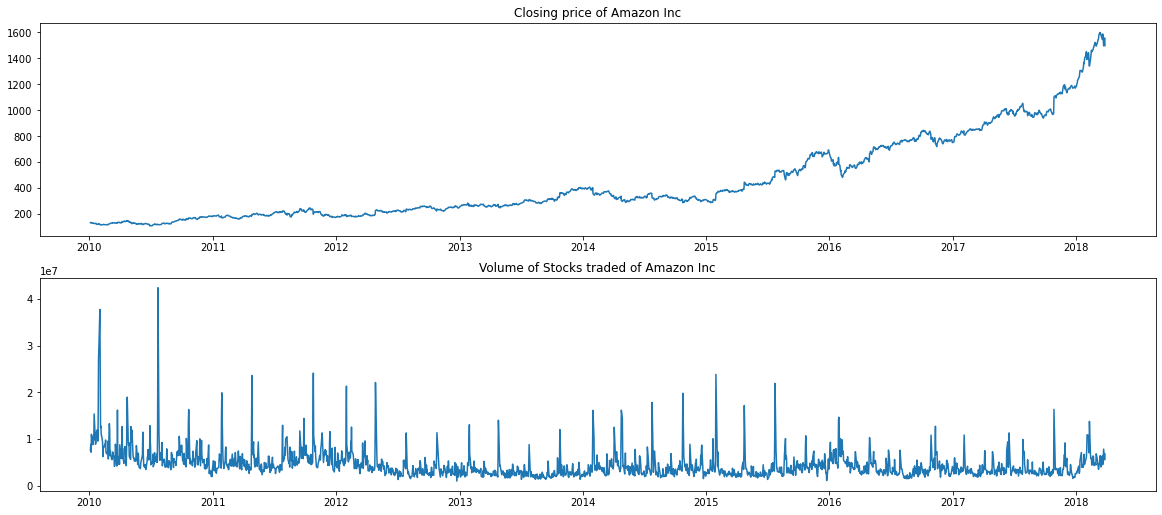

In [109]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

%matplotlib inline
import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)



# Plot the closing prices for `amzn`
fig,ax=plt.subplots(2,1,figsize=(20,5))
plt.subplots_adjust(left=None, bottom=0.1, right=None, top=1.4, wspace=None, hspace=None)
ax[0].plot(amzn['Close'])
ax[0].set_title('Closing price of Amazon Inc')

ax[1].plot(amzn['Volume'])
ax[1].set_title('Volume of Stocks traded of Amazon Inc')


plt.show()

# 1.Common Financial Analysis

It’s time to dive deeper into some of the fundamental financial analyses that can be conducted so that a trading strategy can be developed.

## 1.1. Returns

The **simple daily percentage change** doesn’t take into account dividends and other factors. It represents the amount of percentage change in the value of a stock over a single day of trading.

Note: I have calculated the log return to get a better insight into the growth of returns over time.

In [70]:
import numpy as np

daily_close=amzn[['Adj. Close']]

daily_returns=daily_close.pct_change()

daily_returns.fillna(0,inplace=True)

print(daily_returns)

daily_log_returns=np.log(daily_returns+1)

print(daily_log_returns)

            Adj. Close
Date                  
2010-01-04    0.000000
2010-01-05    0.005900
2010-01-06   -0.018116
2010-01-07   -0.017013
2010-01-08    0.027077
...                ...
2018-03-21   -0.002931
2018-03-22   -0.023871
2018-03-23   -0.031436
2018-03-26    0.040319
2018-03-27   -0.037799

[2070 rows x 1 columns]
            Adj. Close
Date                  
2010-01-04    0.000000
2010-01-05    0.005883
2010-01-06   -0.018282
2010-01-07   -0.017160
2010-01-08    0.026717
...                ...
2018-03-21   -0.002935
2018-03-22   -0.024160
2018-03-23   -0.031940
2018-03-26    0.039528
2018-03-27   -0.038532

[2070 rows x 1 columns]


To justify the use of log returns, lets check if the price is distrubuted log nomally.

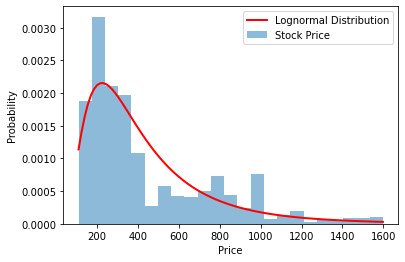

In [110]:
#Plotting Probability Distribution of daily_close along with the best-fit log normal distribution
import scipy
import scipy.stats as stats
from scipy.stats import lognorm

shape, loc, scale = stats.lognorm.fit(daily_close, floc = 10)
x = np.linspace(min(daily_close.to_numpy()), max(daily_close.to_numpy()), 100)
pdf = stats.lognorm.pdf(x, shape, loc, scale)

plt.hist(daily_close, bins='auto', density=True, alpha=0.5, label='Stock Price')
plt.plot(x, pdf, 'r-', lw=2, label='Lognormal Distribution')
plt.xlabel('Price')
plt.ylabel('Probability')
plt.legend()
plt.show()


Since our price data roughly fits a lognormal distribution, we can compute log returns for our dataset.

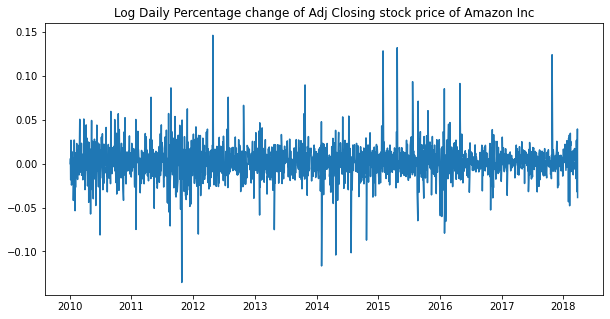

In [111]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(daily_log_returns)
ax.set_title('Log Daily Percentage change of Adj Closing stock price of Amazon Inc')
plt.show()

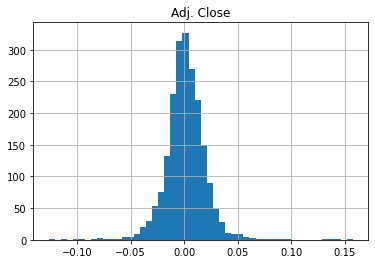

        Adj. Close
count  2070.000000
mean      0.001358
std       0.019615
min      -0.126568
25%      -0.008346
50%       0.000938
75%       0.011756
max       0.157457


In [112]:
#Plotting Distribution of daily_percenatge_returns

daily_returns.hist(bins=50)
plt.show()

print(daily_returns.describe())

The distribution looks very symmetrical and normally distributed, i.e. the daily changes are center around the bin 0.00. We can see that the mean is very close to the 0.00 bin and that the standard deviation is 0.02.

#### Calculating monthly and quaterly percentage returns

In [114]:
# Resample `amzn` to business months, take last observation as value 
monthly_returns = amzn.resample('BM').apply(lambda x: x[-1])

monthly_change=monthly_returns.pct_change()

# Resample `amzn` to quarters, take the mean as value per quarter
quarter_returns = amzn.resample("4M").mean()

# Calculate the quarterly percentage change
quarter_change=quarter_returns.pct_change()

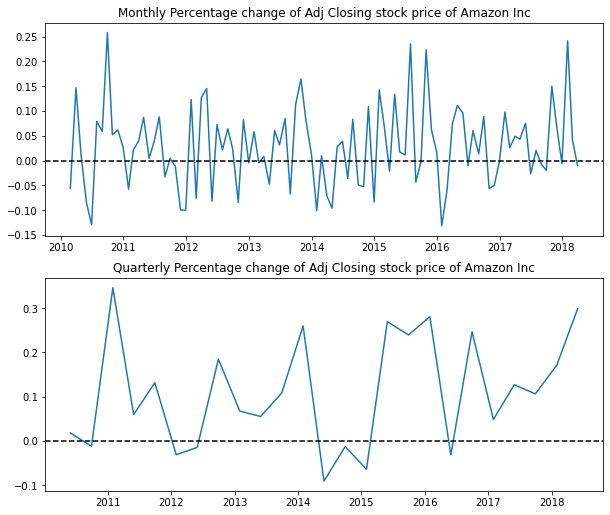

In [115]:
fig,ax=plt.subplots(2,1,figsize=(10,5))
plt.subplots_adjust(left=None, bottom=0.1, right=None, top=1.4, wspace=None, hspace=None)
ax[0].plot(monthly_change['Adj. Close'])
ax[0].set_title('Monthly Percentage change of Adj Closing stock price of Amazon Inc')
ax[0].axhline(0,c='black',ls='--')

ax[1].plot(quarter_change['Adj. Close'])
ax[1].set_title('Quarterly Percentage change of Adj Closing stock price of Amazon Inc')
ax[1].axhline(0,c='black',ls='--')

plt.show()

##### Cumulative Daily Return
The cumulative daily return is useful to determine the value of an investment at regular intervals

In [116]:
cum_daily_return=(1+daily_returns).cumprod()
print(cum_daily_return)

            Adj. Close
Date                  
2010-01-04    1.000000
2010-01-05    1.005900
2010-01-06    0.987677
2010-01-07    0.970874
2010-01-08    0.997162
...                ...
2018-03-21   11.813742
2018-03-22   11.531740
2018-03-23   11.169231
2018-03-26   11.619567
2018-03-27   11.180358

[2070 rows x 1 columns]


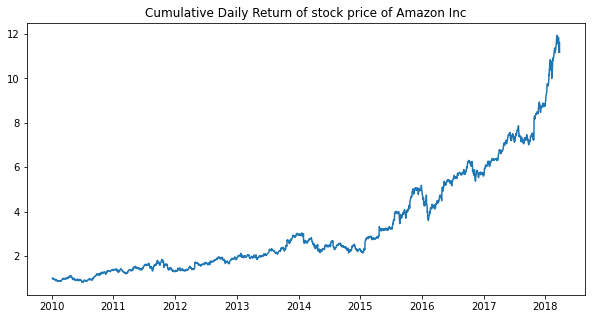

In [117]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(cum_daily_return)
ax.set_title('Cumulative Daily Return of stock price of Amazon Inc')
plt.show()

We can clearly see that the cumulative daily returns of amazon stock price is steadily increasing over time.

#### Calculating Cumulative monthly returns

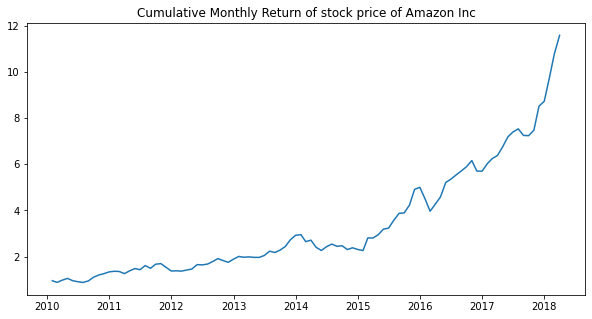

In [118]:
cum_monthly_return=cum_daily_return.resample('M').mean()
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(cum_monthly_return)
ax.set_title('Cumulative Monthly Return of stock price of Amazon Inc')
plt.show()

Although these metrics depict some fundamental behaviour of the stock, comparing the data with other stocks will add more perspective to the stock movements compared to other stocks withing the same industry.

Let's get more stock data of AMAZON, MICROSOFT, IBM and GOOGLE and gather it into one big dataframe

In [125]:
import datetime
def get(tickers, startdate, enddate):
    """ticker:Symbol of the stock."""
    def data(ticker):
        return (quandl.get("WIKI/"+ticker, start_date=startdate, end_date=enddate))
    datas = map (data, tickers)
    return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

tickers = ['AMZN', 'MSFT', 'IBM', 'GOOG']
all_data = get(tickers, datetime.datetime(2010, 1, 1), datetime.datetime(2023, 7, 31))

In [126]:
all_data

Open      High      Low    Close      Volume  Ex-Dividend  Split Ratio  Adj. Open  Adj. High  Adj. Low  Adj. Close  Adj. Volume
Ticker Date                                                                                                                                          
AMZN   2010-01-04   136.25   136.610   133.14   133.90   7599900.0          0.0          1.0     136.25    136.610    133.14      133.90    7599900.0
       2010-01-05   133.43   135.479   131.81   134.69   8851900.0          0.0          1.0     133.43    135.479    131.81      134.69    8851900.0
       2010-01-06   134.60   134.730   131.65   132.25   7178800.0          0.0          1.0     134.60    134.730    131.65      132.25    7178800.0
       2010-01-07   132.01   132.320   128.80   130.00  11030200.0          0.0          1.0     132.01    132.320    128.80      130.00   11030200.0
       2010-01-08   130.56   133.680   129.03   133.52   9830500.0          0.0          1.0     130.56    133.680    129.03      133.52    9830500.0
...                    ...       ...      ...      ...         ...          ...          ...        ...        ...       ...         ...          ...
GOOG   2018-03-21  1092.74  1106.300  1085.15  1090.88   1640709.0          0.0          1.0    1092.74   1106.300   1085.15     1090.88    1640709.0
       2018-03-22  1081.88  1082.900  1045.91  1049.08   2580374.0          0.0          1.0    1081.88   1082.900   1045.91     1049.08    2580374.0
       2018-03-23  1047.03  1063.360  1021.22  1021.57   2113497.0          0.0          1.0    1047.03   1063.360   1021.22     1021.57    2113497.0
       2018-03-26  1046.00  1055.630  1008.40  1053.21   2558385.0          0.0          1.0    1046.00   1055.630   1008.40     1053.21    2558385.0
       2018-03-27  1063.00  1064.840   996.92  1005.10   3029471.0          0.0          1.0    1063.00   1064.840    996.92     1005.10    3029471.0

[7219 rows x 12 columns]

### Visualizing this dataframe

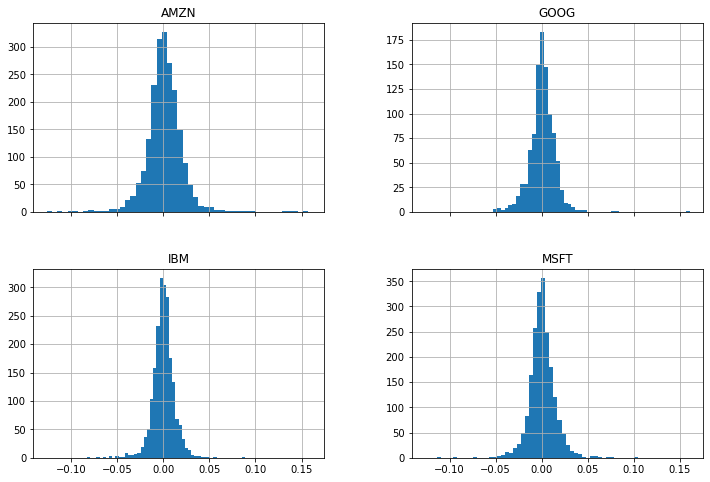

In [182]:
# Isolate the `Adj Close` values and transform the DataFrame
daily_close_px = all_data[['Adj. Close']].reset_index().pivot('Date', 'Ticker', 'Adj. Close')

# Calculate the daily percentage change for `daily_close_px`
daily_pct_change = daily_close_px.pct_change()

# Plot the distributions
daily_pct_change.hist(bins=50, sharex=True, figsize=(12,8))

# Show the resulting plot
plt.show()

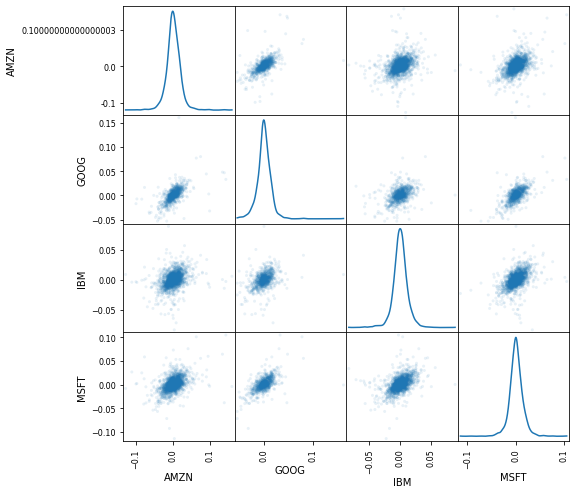

In [209]:
# Plot a scatter matrix with the `daily_pct_change` data 
pd.plotting.scatter_matrix(daily_pct_change, diagonal='kde', alpha=0.1,figsize=(8,8))

# Show the plot
plt.show()

## 1.2. Moving Windows

Moving windows are there when you compute the statistic on a window of data represented by a particular period of time and then slide the window across the data by a specified interval. That way, the statistic is continually calculated as long as the window falls first within the dates of the time series.


Date
2018-03-14    1.4484257k
2018-03-15    1.4556087k
2018-03-16    1.4625678k
2018-03-19    1.4688265k
2018-03-20    1.4753065k
2018-03-21    1.4807895k
2018-03-22    1.4854542k
2018-03-23    1.4883945k
2018-03-26    1.4922398k
2018-03-27    1.4942240k
Name: Adj. Close, dtype: float64


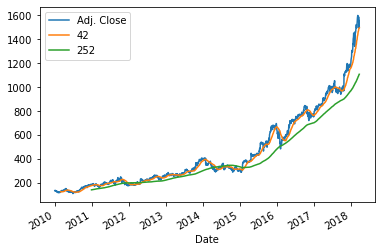

In [210]:
# Isolate the adjusted closing prices 
adj_close_px = amzn['Adj. Close']

# Calculate the moving average
moving_avg = adj_close_px.rolling(window=40).mean()

# Inspect the result
print(moving_avg[-10:])

# Short moving window rolling mean
amzn['42'] = adj_close_px.rolling(window=40).mean()

# Long moving window rolling mean
amzn['252'] = adj_close_px.rolling(window=252).mean()

# Plot the adjusted closing price, the short and long windows of rolling means
amzn[['Adj. Close', '42', '252']].plot()

# Show plot
plt.show()

We can clearly see here that as we increase the size of the window the plot becomes smoother and smoother.

## 1.3 Volatility Calculation

The volatility of a stock is a measurement of the change in variance in the returns of a stock over a specific period of time. It is common to compare the volatility of a stock with another stock to guage which may have less risk or to a market index to examine the stock’s volatility in the overall market. Generally, the higher the volatility, the riskier the investment in that stock, which results in investing in one over another.

The moving historical standard deviation of the log returns—i.e. the moving historical volatility—is more of interest here.

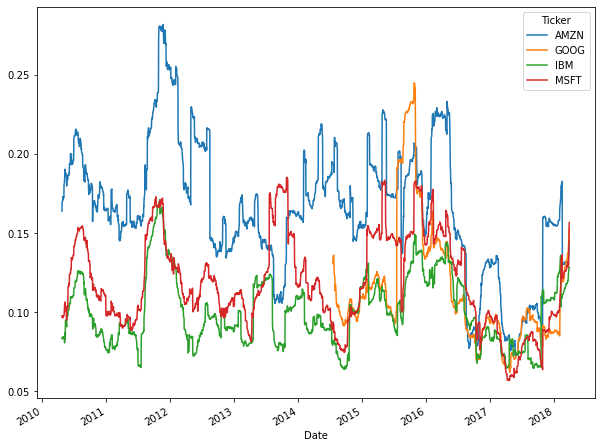

In [211]:
# Define the minumum of periods to consider 
min_periods = 75 

# Calculate the volatility
vol = daily_pct_change.rolling(min_periods).std() * np.sqrt(min_periods) 

# Plot the volatility
vol.plot(figsize=(10, 8))

# Show the plot
plt.show()

Note that the size of the window can and will change the overall result: if you take the window wider and make min_periods larger, your result will become less representative. If you make it smaller and make the window more narrow, the result will come closer to the standard deviation.

Considering all of this, you see that it’s definitely a skill to get the right window size based upon the data sampling frequency.

# 2. Building a Trading Strategy

We will work with two common trading strategies: the **momentum strategy** and **reversion strategy**.

Firstly, the **momentum strategy** is also called divergence or trend trading. When you follow this strategy, you do so because you believe the movement of a security will continue in its current direction. We believe in this strategy that stocks have momentum or upward or downward trends,that we can detect and monetize. 

Some examples of this strategy are the moving average crossover, the dual moving average crossover, and turtle trading:

  1. The **moving average crossover** is when the price of an asset moves from one side of moving              average to other. This cross-over represents a change in momentum and can be used as a point of        making the decision to enter or exit the market. I will work on an exmaple here which is the          'Hello World' of qauntitative trading.
    
  2. The **dual moving average cross-over** occurs when a short-term average crosses a long-term                average. This signal is used to identify that momentum is shifting in the direction of the            short-term average. A buy signal is generated when the short-term average crosses the long-term        average and rises above it, while a sell signal is triggered when short-term average crosses          the long-term average and falls below it.
  
  3. **Turtle trading** is a well-known strategy that was originally taught by Richard Dennis. The basic        strategy is to buy futures on a 20-day high and sell on a 20-day low.
    

Secondly, the **reversion strategy**, which is also known as convergence or cyclic trading. This strategy departs from the belief that the movement of a security will eventually reverse. For example, in **mean reversion strategy**, we believe that stocks return to their mean and that you can monetize when it deviates from  that mean.

Another example of this strategy, besides the mean reversion strategy, is the pairs trading mean-reversion, which is similar to the mean reversion strategy. While the mean reversion strategy basically states that stocks return to their mean, the pairs trading strategy extends the hypothesis and states that if two stocks can be identified that have a relatively high correlation, the change in the difference in price between the two stocks can be used to signal trading events if one of the two moves out of correlation with the other. This means that if the correlation between two stocks has decreased, the stock with the higher price can be considered to be in a short position. It should be sold because the higher-priced stock will return to the mean. The lower-priced stock, on the other hand, will be in a long position because the price will rise as the correlation will return to normal.

Besides these two most frequent strategies, there are also other ones that you might come across once in a while, such as the forecasting strategy, which attempts to predict the direction or value of a stock, in this case, in subsequent future time periods based on certain historical factors. There is also the High-Frequency Trading (HFT) strategy, which monetizes the sub-millisecond market microstructure.

### 2.1 A Simple Trading Strategy

I will start with a 'hello world' of quantitative trading: the **moving average crossover**. I will create two seperate Simple Moving Averages(SMA) of a time series with differing lookback periods, let's say 40 and 100 days. If the short moving average exceeds the long moving average then we will go long, if the long moving average exceeds the short moving average then we will exit.  

Going long is when we think that the stock price will go up and will sell at a higher price in the future (buy signal); When I'll go short, I'll sell the stock, expecting that I can buy it back at a lower price and realize a profit (sell signal).

In [212]:
# Initialize the short and long windows
short_window = 40
long_window = 100

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=amzn.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = amzn['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = amzn['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

#Create Signals
signals['signal'][short_window:]=np.where(signals['short_mavg'][short_window:]>
                                          signals['long_mavg'][short_window:],1.0,0.0)

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
print(signals[40:])

               signal   short_mavg    long_mavg  positions
Date                                                      
2010-03-03  0.0000000  122.6374500  122.9121463  0.0000000
2010-03-04  0.0000000  122.4834500  123.0459048  0.0000000
2010-03-05  0.0000000  122.3999500  123.1822791  0.0000000
2010-03-08  0.0000000  122.4027000  123.3397273  0.0000000
2010-03-09  0.0000000  122.2852000  123.4615111  0.0000000
...               ...          ...          ...        ...
2018-03-21  1.0000000   1.4807895k   1.2971925k  0.0000000
2018-03-22  1.0000000   1.4854542k   1.3029044k  0.0000000
2018-03-23  1.0000000   1.4883945k   1.3081357k  0.0000000
2018-03-26  1.0000000   1.4922398k   1.3126848k  0.0000000
2018-03-27  1.0000000   1.4942240k   1.3165468k  0.0000000

[2030 rows x 4 columns]


When the **signal column** in the dataframe changes from **1** to **0**, the **position** changes to **-1** which is a **sell** signal. Similarly, when the **signal** column in the dataframe changes from **0** to **1**, the **position** column changes to **+1** which is a **buy** signal. When the **position** is **0** then there is no buy/sell action taken.

#### Plotting the strategy

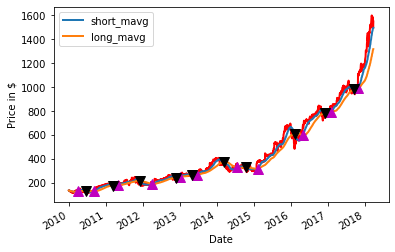

In [213]:
# Import `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, ylabel='Price in $')

# Plot the closing price
amzn['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

The **purple** **upward facing triangles** represent a **buy** signal and the **black downward facing triangles** represent a **sell** signal. 

Note: In this strategy we initiate a buy signal whenever the short term moving average exceeds the long term moving average and a sell signal is initiated whenever the long term moving average exceeds the short term moving average.

# 3. Backtesting the Trading Strategy

Now that we’ve got a trading strategy at hand, it’s a good idea to also backtest it and calculate its performance. 

Backtesting is, besides just “testing a trading strategy”, testing the strategy on relevant historical data to make sure that it’s an actual viable strategy before you start making moves. With backtesting, a trader can simulate and analyze the risk and profitability of trading with a specific strategy over a period of time. However, when you’re backtesting, it’s a good idea to keep in mind that there are some pitfalls, which might not be obvious to you when you’re just starting out.

For example, there are external events, such as market regime shifts, which are regulatory changes or macroeconomic events, which definitely influence your backtesting. Also, liquidity constraints, such as the ban of short sales, could affect your backtesting heavily.

Next, there are pitfalls which you might introduce yourself when you, for example, overfit a model (optimization bias), when you ignore strategy rules because you think it is benefitial (interference), or when you accidentally introduce information into past data (lookahead bias).

### Backtesting Components

The backtester usually consists of some four essential components, which should usually be present in every backtester:
1. A data handler, which is an interface to a set of data,
2. A strategy, which generates a signal to go long or go short based on the data,
3. A portfolio, which generates orders and manages Profit & Loss (also known as “PnL”), and
4. An execution handler, which sends the order to the broker and receives the “fills” or signals that the stock has been bought or sold.

### 3.1. Implementation of  a Simple Backtester

We’ll focus here how we can get started on creating a portfolio which can generate orders and manages the profit and loss.

In [214]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['AMZN'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(amzn['Adj. Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(amzn['Adj. Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(amzn['Adj. Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio.head())

                 AMZN   holdings          cash         total    returns
Date                                                                   
2010-01-04  0.0000000  0.0000000  100.0000000k  100.0000000k        NaN
2010-01-05  0.0000000  0.0000000  100.0000000k  100.0000000k  0.0000000
2010-01-06  0.0000000  0.0000000  100.0000000k  100.0000000k  0.0000000
2010-01-07  0.0000000  0.0000000  100.0000000k  100.0000000k  0.0000000
2010-01-08  0.0000000  0.0000000  100.0000000k  100.0000000k  0.0000000


#### Visualizing the portfolio value (result of backtesting)

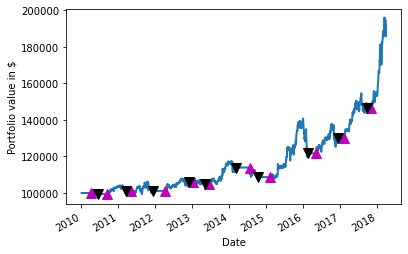

In [215]:
# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

## Evaluating Moving Average Crossover Strategy 

First, we can use the **Sharpe ratio** to get to know whether the portfolio’s returns are the result of the fact that we decided to make smart investments or to take a lot of risks.

The ideal situation is, of course, that the returns are considerable but that the additional risk of investing is as small as possible. That’s why, the greater the portfolio’s Sharpe ratio, the better: the ratio between the returns and the additional risk that is incurred is quite OK. Usually, a ratio greater than 1 is acceptable by investors, 2 is very good and 3 is excellent.

In [216]:
# Isolate the returns of your strategy
returns = portfolio['returns']

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)

0.8517858826755688


Next, we can also calculate a **Maximum Drawdown**, which is used to measure the the largest single drop from peak to bottom in the value of a portfolio, so before a new peak is achieved. In other words, the score indicates the risk of a portfolio chosen based on a certain strategy.

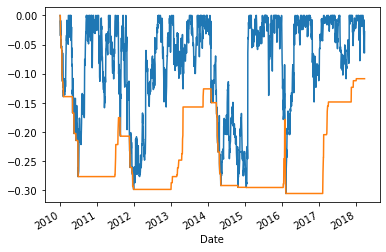

-0.30534461143853486


In [220]:
# Define a trailing 252 trading day window
window = 252

# Calculate the max drawdown in the past window days for each day 
rolling_max = amzn['Adj. Close'].rolling(window, min_periods=1).max()
daily_drawdown = amzn['Adj. Close']/rolling_max - 1.0

# Calculate the minimum (negative) daily drawdown
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

# Plot the results
daily_drawdown.plot()
max_daily_drawdown.plot()

# Show the plot
plt.show()

print(min(max_daily_drawdown))
